In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.model_selection import cross_validate, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

In [3]:
df = yf.download('BTC-USD',start='2025-01-01', end='2025-9-24', interval="1d")
df_future = yf.download('BTC-USD',start='2025-9-25', end='2025-10-25', interval="1d")
df.sample(3)

C:\Users\davood\AppData\Local\Temp\ipykernel_2228\136167839.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download('BTC-USD',start='2025-01-01', end='2025-9-24', interval="1d")
[*********************100%***********************]  1 of 1 completed
C:\Users\davood\AppData\Local\Temp\ipykernel_2228\136167839.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_future = yf.download('BTC-USD',start='2025-9-25', end='2025-10-25', interval="1d")
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
Date,,,,,
2025-04-21,87518.906250,88460.093750,85143.835938,85171.539062,41396190190
2025-07-19,117939.976562,118541.398438,117388.414062,117998.125000,47564562765
2025-02-19,96635.609375,96855.593750,95011.968750,95532.531250,28990872862


In [4]:
df.columns

MultiIndex([( 'Close', 'BTC-USD'),
            (  'High', 'BTC-USD'),
            (   'Low', 'BTC-USD'),
            (  'Open', 'BTC-USD'),
            ('Volume', 'BTC-USD')],
           names=['Price', 'Ticker'])

In [5]:
df.columns = df.columns.droplevel(1)
df_future.columns = df_future.columns.droplevel(1)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 266 entries, 2025-01-01 to 2025-09-23
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   266 non-null    float64
 1   High    266 non-null    float64
 2   Low     266 non-null    float64
 3   Open    266 non-null    float64
 4   Volume  266 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 12.5 KB


In [6]:
df.describe()

Price,Close,High,Low,Open,Volume
count,266.000000,266.000000,266.000000,266.000000,2.660000e+02
mean,102012.877262,103487.248943,100312.723537,101941.928425,4.946377e+10
std,11648.364245,11458.673179,11888.176355,11645.197270,2.242467e+10
min,76271.953125,80823.890625,74436.679688,76273.562500,9.863214e+09
25%,94495.458984,95397.007812,92870.251953,94434.439453,3.411773e+10
50%,104052.464844,105664.652344,102357.652344,103980.195312,4.766710e+10
75%,111300.431641,112614.347656,110164.740234,111211.964844,6.160076e+10
max,123344.062500,124457.117188,118959.195312,123339.398438,1.817464e+11


In [7]:
df['predClose'] = df['Close'].shift(-1)
df = df[:-1] 
X = df[['Open','High','Low','Volume']]
y = df['predClose']
df_future['predClose'] = df_future['Close'].shift(-1)
df_future = df_future[:-1] 
X_future = df_future[['Open','High','Low','Volume']]
y_future = df_future['predClose']


In [8]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('linear', LinearRegression())
])

scoring = ['r2', 'neg_root_mean_squared_error']
evaluation_df = pd.DataFrame(np.zeros((1,2)), columns=scoring, index=['linear'])
tss = TimeSeriesSplit(n_splits=5)
cross_validation = cross_validate(pipeline, X, y, cv=tss, scoring=scoring, return_train_score=False)
evaluation_df.iloc[:,:] =[cross_validation['test_r2'].mean(), -cross_validation['test_neg_root_mean_squared_error'].mean()]
evaluation_df

,r2,neg_root_mean_squared_error
linear,0.587759,2415.08266


In [9]:
pipeline.fit(X, y)  # fit روی کل داده تاریخی
y_future_pred = pipeline.predict(X_future)


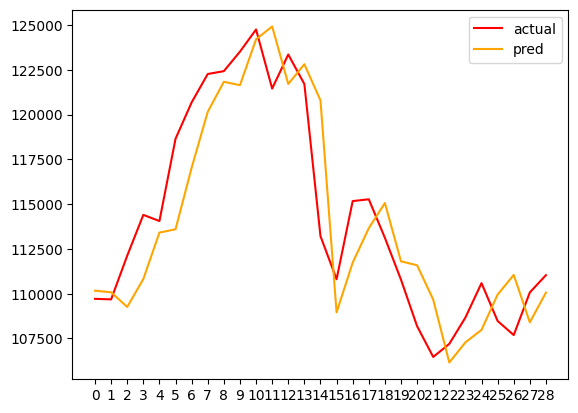

In [10]:
a= np.arange(len(df_future.index))

plt.plot(a, y_future, color = 'red', label = 'actual')
plt.plot(a, y_future_pred, color = 'orange', label = 'pred')
plt.xticks(a)
plt.legend()
plt.show()

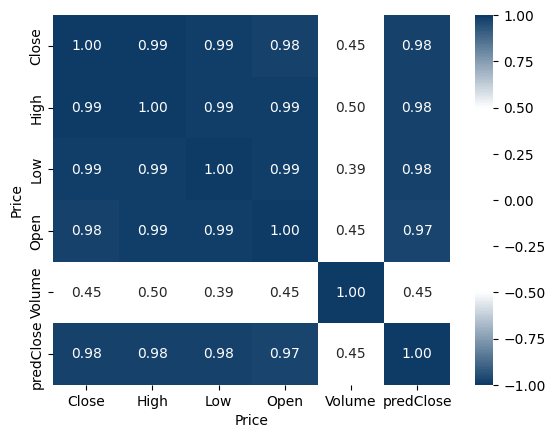

Price  Price    
Close  High         0.992929
       Low          0.991523
       Open         0.983657
       predClose    0.983661
High   Low          0.988618
       Open         0.991764
       predClose    0.978486
Low    Open         0.991487
       predClose    0.979157
Open   predClose    0.971400
dtype: float64

In [11]:
corr_matrix = df.corr()
colors = [
    (0.0, "#0D3B66"),
    (0.25, "white"),
    (0.75, "white"),
    (1.0, "#0D3B66")
]
cmap = LinearSegmentedColormap.from_list('', colors)
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap=cmap, vmax=1, vmin=-1)
plt.show()
corr_matrix_filtered = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k =1).astype('bool'))
corr_matrix_filtered = corr_matrix_filtered[corr_matrix_filtered>0.8].stack()
corr_matrix_filtered
# corr_matrix_filtered = corr_matrix_filtered.reset_index().rename(columns={'level_0':'feature1', 'level_1':'feature2', 0:'corr'})
# corr_matrix_filtered = corr_matrix_filtered.sort_values(by='corr',ascending=False)

# f1 = []
# f2 = []
# for feature1 in corr_matrix_filtered['feature1']:
#    f1.append(df[feature1].corr(df['predClose']))
# for feature2 in corr_matrix_filtered['feature2']:
#   f2.append(df[feature2].corr(df['predClose']))
# corr_matrix_filtered['targetCorrWithF1'] = f1
# corr_matrix_filtered['targetCorrWithF2'] = f2
# corr_matrix_filtered.reset_index(drop=True, inplace=True)
# corr_matrix_filtered